# MarlimR3D - Comparison

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Figure 4 from Correa and Menezes (2019), but noise-free data

In [3]:
data = xr.load_dataset('marlim_data.nc', engine='h5netcdf')
egd = xr.load_dataset('results/marlim_emg3d.nc', engine='h5netcdf')
cst = xr.load_dataset('results/marlim_custEM_p2.nc', engine='h5netcdf')

In [4]:
# Receiver positions (reciprocity)
rec_x = egd.src_x[::2]

# Line styles
ls = ['co', 'ys', 'm*', 'gd', 'rv', 'b^']

def extract_line(d, n):
    return np.abs(getattr(d, n).data[::2, :, :] + 1j*getattr(d, n).data[1::2, :, :])

<IPython.core.display.Javascript object>


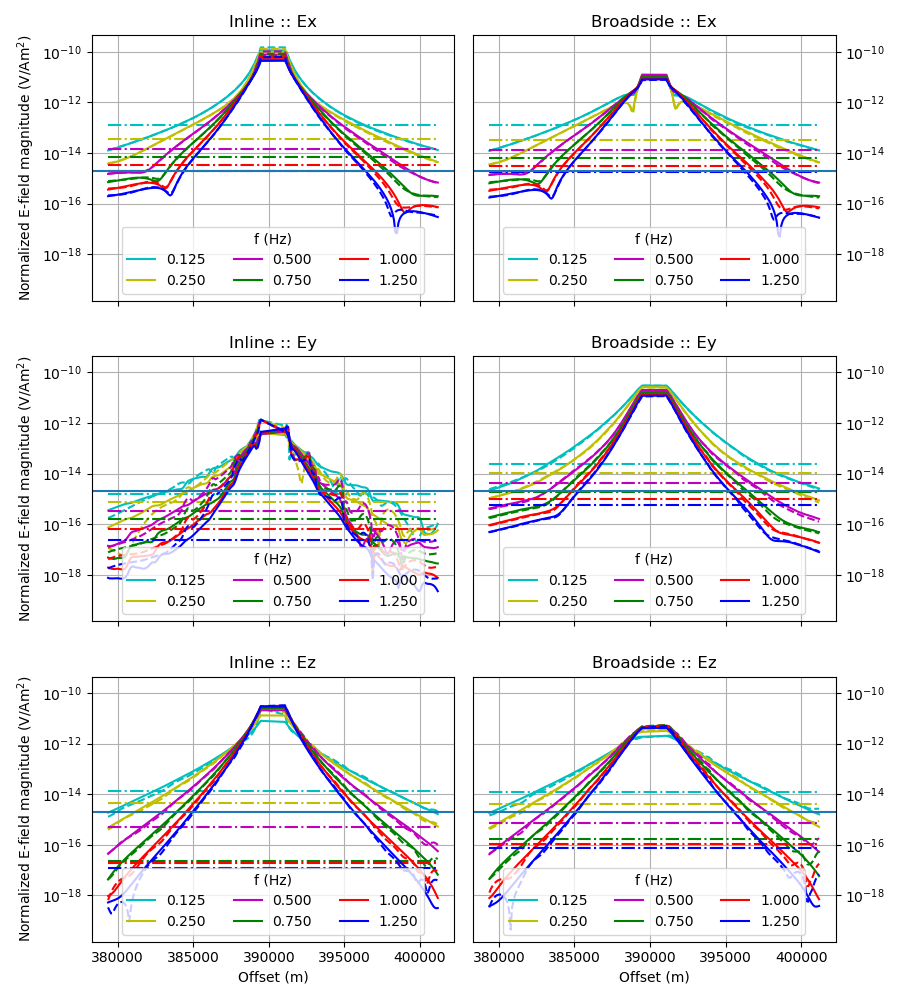

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)

    # Loop over components Ex, Ey, Ez
    for ii, comp in enumerate(data.components.values[:3]):

        plt.sca(axs[ii, iii])
        plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

        # Loop over frequencies
        for i, freq in enumerate(data.freqs.values):

            # Plot this component/frequency
            plt.plot(rec_x, tdat[:, i, ii], ls[i][0]+'-', label=f"{freq:4.3f}")
            plt.plot(rec_x, tegd[:, i, ii], ls[i][0]+'--')
            plt.plot(rec_x, tcst[:, i, ii], ls[i][0]+'-.')
            
            # Plot difference
            # plt.plot(rec_x, abs(tdat[:, i, ii]-tegd[:, i, ii]), ls[i][0]+'-')

        plt.axhline(2e-15)
        plt.legend(title='f (Hz)', loc='lower center', ncol=3)
        plt.grid('on')
        plt.yscale('log')
        
        if ii == 2:
            plt.xlabel('Offset (m)')
        if iii == 0:
            plt.ylabel('Normalized E-field magnitude (V/Am$^2$)')
        else:
            axs[ii, iii].yaxis.set_ticks_position('right')
            axs[ii, iii].yaxis.set_label_position('right')

plt.tight_layout()
plt.show()